### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.646776,0],
    [4.087265,1], 
    [4.536415,0],
    [5.3898,0]
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 4.5, 3.2, 4.5]
current_speeds = [0.5, -0.5, -1, 0] 
V_g_profile = [3.2, 2.5, 2, 2.5]
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile": V_g_profile[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

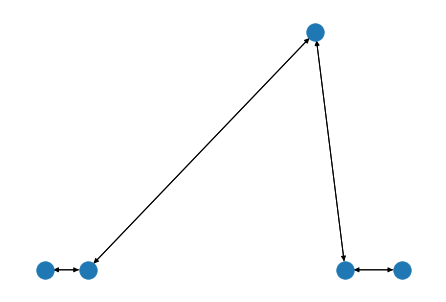

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground Profile {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile"]))

General depth for edge ('Node 0', 'Node 1') is 6
Current speed for edge ('Node 0', 'Node 1') is 0.5
Vessel Speed To Ground Profile ('Node 0', 'Node 1') is 3.2
General depth for edge ('Node 1', 'Node 0') is 6
Current speed for edge ('Node 1', 'Node 0') is 0.5
Vessel Speed To Ground Profile ('Node 1', 'Node 0') is 3.2
General depth for edge ('Node 1', 'Node 2') is 4.5
Current speed for edge ('Node 1', 'Node 2') is -0.5
Vessel Speed To Ground Profile ('Node 1', 'Node 2') is 2.5
General depth for edge ('Node 2', 'Node 1') is 4.5
Current speed for edge ('Node 2', 'Node 1') is -0.5
Vessel Speed To Ground Profile ('Node 2', 'Node 1') is 2.5
General depth for edge ('Node 2', 'Node 3') is 3.2
Current speed for edge ('Node 2', 'Node 3') is -1
Vessel Speed To Ground Profile ('Node 2', 'Node 3') is 2
General depth for edge ('Node 3', 'Node 2') is 3.2
Current speed for edge ('Node 3', 'Node 2') is -1
Vessel Speed To Ground Profile ('Node 3', 'Node 2') is 2
General depth for edge ('Node 3', 'Node 4'

### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 2.56,  # m/s
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.6,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":True, # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "wind_influence": False, # if consider wind influence, set to True; otherwise set to False.
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.9, 
    "C_year": 2000,
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [8]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[4].name)
path_downstream = nx.dijkstra_path(FG, nodes[4].name, nodes[0].name)

### Run simulation


In [9]:
def run_simulation(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [10]:
input_data = {'V_s': [2.56]} # 
input_data

{'V_s': [2.56]}

In [11]:
# create empty plot data
plot_data = {}


vessel = run_simulation(V_g_ave = 2.56 , path = path_upstream )

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
energycalculation.calculate_energy_consumption()

# create dataframe from energy calculation computation
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df
# add/modify some comlums to suit our plotting needs

# df['fuel_kg_per_km'] = (df['total_diesel_consumption_C_year_ICE_mass']/1000) / (df['distance']/1000)  # g/m --> kg/km
# df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
# df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
# df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)

# label = 'V_s = ' + str(input_data['V_s'][index]) 

# # Note that we make a dict to collect all plot data. 
# # We use labels like ['V_s = None P_tot_given = 274 fuel_kg_km'] to organise the data in the dict
# # The [0, 0, 1, 1, 2, 2] below creates a list per section (I think this is the way you use it in your plot)
# # plot_data[label + ' v'] = list(df.distance[[0, 0, 1, 1, 2, 2]]/df.delta_t[[0, 0, 1, 1, 2, 2]])
# # plot_data[label + ' P_tot']   = list(df.P_tot[[0, 0, 1, 1, 2, 2]])
# plot_data[label + ' fuel_kg_per_km']   = list(df.fuel_kg_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
# plot_data[label + ' CO2_g_per_km'] = list(df.CO2_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
# plot_data[label + ' PM10_g_per_km']   = list(df.PM10_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
# plot_data[label + ' NOx_g_per_km']   = list(df.NOx_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
        

5.911210491838602
2.7
4.360447504411457
3.0
3.016063354867997
3
4.404491809824933
2.5


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-11-02 19:22:30.000000,2022-11-03 03:11:14.521476,POINT (0 0),POINT (0.646776 0),207.228211,207.228211,2000,1707.478787,4.227811e+05,4.650581e+05,...,1.940317e+07,15.355025,1.067174,1.340525e+06,823.479052,21310.177378,1707.478787,5.911210,71998.774977,28124.521476
1,2022-11-03 03:11:14.521476,2022-11-04 22:26:24.479563,POINT (0.646776 0),POINT (4.087265 1),401.582001,401.582001,2000,20354.920772,4.797352e+06,5.277075e+06,...,2.313059e+08,183.047849,12.721825,1.521112e+07,7259.944398,210348.803091,20354.920772,4.360448,398617.492704,155709.958087
2,2022-11-04 22:26:24.479563,2022-11-05 11:36:27.685494,POINT (4.087265 1),POINT (4.536415 0),494.669673,494.669673,2000,7633.114705,1.769879e+06,1.946863e+06,...,8.673994e+07,68.643118,4.770697,5.611812e+06,2573.270810,76209.338029,7633.114705,3.016063,121352.207183,47403.205931
3,2022-11-05 11:36:27.685494,2022-11-05 21:54:56.429107,POINT (4.536415 0),POINT (5.3898 0),174.284376,174.284376,2000,1754.414670,4.388821e+05,4.827692e+05,...,1.993653e+07,15.777110,1.096509,1.391577e+06,967.540331,24176.644029,1754.414670,4.404492,94998.383651,37108.743613


In [17]:
from opentnsim.energy import ConsumesEnergy

In [24]:
r = ConsumesEnergy.calculate_residual_resistance(vessel,v=2, h_0=5)
r

4.47612550295072

In [25]:
from opentnsim.energy import ConsumesEnergy

In [14]:
import pandas as pd

data=[[0,-0.86,-0.96],[10,-0.76,-0.93]]

df=pd.DataFrame(data,columns=['AoA','loaded','unloaded'])

df

,AoA,loaded,unloaded
0,0,-0.86,-0.96
1,10,-0.76,-0.93


In [15]:
def drag(angle_of_attack,load):
    cd=[[0,-0.86,-0.96],[10,-0.76,-0.93],[20,-0.62,-0.85],
        [30,-0.45,-0.73],[40,-0.32,-0.62],[50,-0.21,-0.47],
        [60,-0.13,-0.34],[70,-0.06,-0.17],[80,-0.04,-0.06],
        [90,0.02,0.05],[100,0.08,0.14],[110,0.19,0.22],
        [120,0.29,0.29],[130,0.38,0.40],[140,0.47,0.53],
        [150,0.56,0.66],[160,0.61,0.75],[170,0.66,0.79],
        [180,0.63,0.77]]
    
    df=pd.DataFrame(cd,columns=['AoA','loaded','unloaded'])

    if load == 'loaded':
  
        dragcoefficient = df['loaded'].where(df['AoA'] == angle_of_attack).dropna().values[0]
    
    elif load == 'unloaded':
        dragcoefficient = df['unloaded'].where(df['AoA'] == angle_of_attack).dropna().values[0]
        
    return dragcoefficient

drag(0,'unloaded')

-0.96